In [7]:
# Data Tools
import numpy as np
import pandas as pd
import math
from scipy import stats
from scipy.stats import sem

# Visualization Tools
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Test/Train Split
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score

# Helpful Functions
# Reference: https://people.duke.edu/~rnau/mathreg.htm
def standard_error(x_test, y_test, y_pred, p=1):
    n = len(x_test)
    e = y_test - y_pred
    RSS = (e**2).sum()
    sigma = math.sqrt(RSS / (n - (p + 1))) # estimation of standard deviation (aka residual standard error)
    SE = sigma**2 / np.sum((x_test - x_test.mean())**2)
    return math.sqrt(SE)

def residual_standard_error(y_test, y_pred):
    e = y_test - y_pred
    RSS = (e**2).sum()
    RSE = math.sqrt(RSS / (len(y_test) - 2))
    return RSE

def f_statistic(y_test, y_pred, p):
    n = len(y_test)
    e = y_test - y_pred
    RSS = (e**2).sum()
    TSS = ((y_test - y_test.mean())**2).sum()
    F = ((TSS - RSS)/p) / RSS * (n - p - 1)
    return F

def print_coefficient_stats(x_test, y_test, y_pred, lr):
    print('\n=== Coefficient Summary ===')

    for i in range(len(x_test.columns)):
        print('\n' + str(x_test.columns[i]).center(len(x_test.columns[i]) + 2, ' ').center(30, '-'))
        # Coefficient
        print('Coefficient: {:0.4f}'.format(lr.coef_[i]))

        # Standard Error
        print('Standard Error: {:0.4f}'.format(standard_error(x_test[x_test.columns[i]], y_test, y_pred, p=len(lr.coef_))))
        
        # t-statistic
        t_stat = (lr.coef_[i] / standard_error(x_test[x_test.columns[i]], y_test, y_pred, p=len(lr.coef_)))
        print('T-Statistic: {:0.4f}'.format(t_stat))

        # p Value
        p_val = stats.t.sf(np.abs(t_stat), len(x_test[x_test.columns[i]]) - 1) * 2
        print('P Value: {:0.4f}'.format(p_val))

    # Intercept
    print('\n' + str('Intercept').center(len('Intercept') + 2, ' ').center(30, '-'))
    print('Coefficient: {:0.4f}'.format(lr.intercept_))

    
# TODO: Need to fix coefficient stats for multiple linear regression (the problem occurs at the Standard Error)
# TODO: Need to include intercept in the calculations
def coefficient_stats(x_test, y_test, y_pred, lr):
    df_array = []
    headings = ['Feature', 'Coefficient', 'Standard Error', 'T_Statistic', 'p Value']
    for i in range(len(x_test.columns)):
        feature = x_test.columns[i]
        SE = standard_error(x_test[feature], y_test, y_pred, p=len(lr.coef_))
        t_stat = (lr.coef_[i] / standard_error(x_test[feature], y_test, y_pred, p=len(lr.coef_)))
        p_val = stats.t.sf(np.abs(t_stat), len(x_test[feature]) - 1) * 2 # https://stackoverflow.com/questions/17559897/python-p-value-from-t-statistic
        df_array.append([
            feature,
            lr.coef_[i],
            SE,
            t_stat,
            p_val
        ])
    return pd.DataFrame(df_array, columns=headings)

metric_funcs = [
    explained_variance_score,
    # mean_absolute_error,
    mean_squared_error,
    # mean_squared_log_error,
    # median_absolute_error,
    residual_standard_error,
    r2_score
]

def print_regression_metrics(y_test, y_pred, metric_funcs):
    print('=== Statistics Summary ===')

    for func in metric_funcs:
        print(func.__name__ + ': {:0.4f}'.format(func(y_test, y_pred)))

def regression_metrics(y_test, y_pred, metric_funcs, p=1):
    df_array = []
    headings = ['Metric', 'Value']

    for func in metric_funcs:
        df_array.append([
            ' '.join([x.capitalize() for x in func.__name__.split('_')]),
            func(y_test, y_pred)
        ])

    # F-Statistic
    if p:
        df_array.append([
            'F-Statistic',
            f_statistic(y_test, y_pred, p)
        ])

    return pd.DataFrame(df_array, columns=headings)

In [8]:
df = pd.read_csv('data/train.csv')

In [9]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [10]:
MSSubClasses = {
    20: '1-STORY 1946 & NEWER ALL STYLES',
    30: '1-STORY 1945 & OLDER',
    40: '1-STORY W/FINISHED ATTIC ALL AGES',
    45:	'1-1/2 STORY - UNFINISHED ALL AGES',
    50: '1-1/2 STORY FINISHED ALL AGES',
    60: '2-STORY 1946 & NEWER',
    70: '2-STORY 1945 & OLDER',
    75:	'2-1/2 STORY ALL AGES',
    80: 'SPLIT OR MULTI-LEVEL',
    85:	'SPLIT FOYER',
    90: 'DUPLEX - ALL STYLES AND AGES',
    120: '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
    150: '1-1/2 STORY PUD - ALL AGES',
    160: '2-STORY PUD - 1946 & NEWER',
    180: 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
    190: '2 FAMILY CONVERSION - ALL STYLES AND AGES'
}

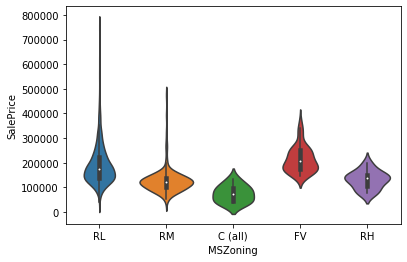

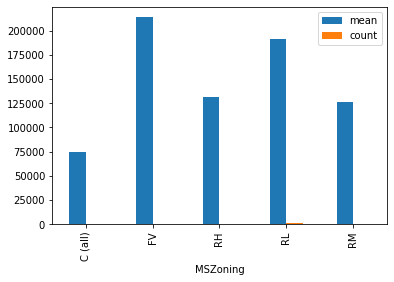

KeyError: 'C (all)'

In [11]:
sns.violinplot(
    x=df.MSZoning,
    y=df.SalePrice
)

plt.show()

sp_by_sc = df.groupby('MSZoning').SalePrice.agg(['mean', 'count'])

sp_by_sc.plot(kind='bar')
plt.show()

sp_by_sc_i = sp_by_sc.index
sp_by_sc_vals = sp_by_sc.values
for i in range(len(sp_by_sc_i)):
    print('{}:\n\tmean: ${:,.2f}\n\tcount: {}'.format(MSSubClasses[sp_by_sc_i[i]], sp_by_sc_vals[i][0], sp_by_sc_vals[0][1]))

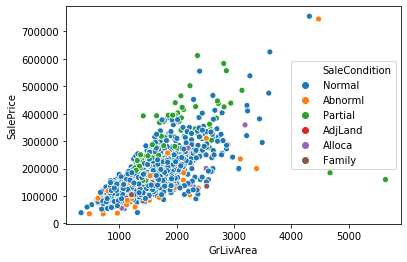

In [ ]:
sns.scatterplot(
    x='GrLivArea',
    y='SalePrice',
    hue='SaleCondition',
    data=df
)

In [ ]:
sns.pairplot(df.loc[:, ['TotalBsmtSF', 'LowQualFinSF', 'GrLivArea', 'SalePrice']])

NameError: name 'sns' is not defined